# Brand analysis notebook

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
import bisect
from IPython.display import IFrame
%matplotlib inline

In [2]:
import findspark
findspark.init()

import pyspark
conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '1g')\
    .set('spark.driver.memory', '1g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

### Test and example

##### @todo: why do I need to run it twice?

In [3]:
# New dataset format. salesRankCat and salesRankPos are always included together
sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'salesRankCat' in x)\
    .take(1)

[{'asin': '9868238854',
  'average_rating': 5.0,
  'bought_together': [],
  'buy_after_viewing': ['B0002MS7O2',
   'B0002D00QE',
   'B000RW20Q8',
   '0882848143'],
  'category': ['Musical Instruments',
   'Band & Orchestra',
   'Wind & Woodwinds',
   'Recorders'],
  'description': 'Woodnote Tenor Recorder  was made of High performance ABS Plastic Resin and are highly recommended by many buyers and collectors.',
  'helpful_fraction': 1.0,
  'imUrl': 'http://ecx.images-amazon.com/images/I/51h8cIN5FaL._SY300_.jpg',
  'num_reviews': 2,
  'price': 61.41,
  'salesRankCat': 'Musical Instruments',
  'salesRankPos': 60253,
  'title': 'Woodnote Wood Grain Tenor Recorder-Baroque fingering/3 pieces construction'}]

### Load dataset, select category, filter entries

In [4]:
# Collect the products in the "Headphones" category
#cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
cat = ['Electronics', 'Camera & Photo', 'Digital Cameras']
#.filter(lambda x: 'salesRankCat' in x and 'price' in x and 'brand' in x and 'related' in x and 'average_rating' in x)\
#cat = ['Electronics']
#cat = ['Cell Phones & Accessories']
records = sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'title' in x)\
    .filter(lambda x: len(x['category']) >= len(cat) and x['category'][:len(cat)] == cat)\
    .collect()

### Brand data augmentation and filtering

In [5]:
brands_total = []

for r in records:
    if 'brand' in r:
        if r['brand'] in r['title'] and r['brand'] != 'Generic':
            brands_total.append(r['brand'])

        
brands_total_set = sorted(set(brands_total))
print("There are " + str(len(records)) + " records in category.")
print("There are " + str(len(brands_total_set)) + " brands overall.")

There are 5693 records in category.
There are 73 brands overall.


In [6]:
count = 0
for r in records:
    if 'brand' in r and r['brand'] == 'Generic':
        r['brand'] = ""
    if 'brand' not in r or r['brand'] not in r['title']:
        # find matching brands in title
        matching = [b for b in brands_total_set if b in r['title']]
        # filter null brands ''
        matching = list(filter(lambda x: x != '', matching))
        #print(matching)
        # only a brand should be found in title
        if len(matching) == 1:
            r['brand'] = matching[0]
            count += 1
            
print(count, "brands have been added")

3555 brands have been added


In [7]:
records = list(filter(lambda x: 'brand' in x, records))
print("There are " + str(len(records)) + " records in category.")

There are 4809 records in category.


## NB: Create graph with the following code!

In [8]:
from graph import ProductGraph
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

3276

In [9]:
count = 0
dim_cliques = 2
for c in cliques:
    if len(c) < dim_cliques:
        continue
    count += 1
    for i in c:
        print('*',g.records[i]['title'], ' - $', g.records[i]['price'])
    print('------')
    
print("\nThere are", len(g.records), "products.")
print("Total number of cliques:", count)

* Southern Telecom Emerson Action Camera Black Digital Cameras  - $ 36.87
* Emerson EVC355BLHD Action Video Camera with 1.2-Inch LCD (Blue)  - $ 40.39
------
* Canon EOS Rebel SL1 18.0 MP CMOS Digital SLR with EF-S 18-55mm IS STM Lens  - $ 649.0
* Canon EOS Rebel SL1 18.0 MP CMOS Digital SLR Full HD 1080 Video Body with EF-S 18-55mm IS STM Lens With 58mm 2x Professional Lens +High Definition 58mm Wide Angle Lens + Auto Flash + Uv Filter Kit with 24GB Complete Deluxe Accessory Bundle  - $ 649.95
------
* Canon PowerShot ELPH 340 HS 16MP Digital Camera (Black)  - $ 179.0
* Canon PowerShot ELPH 330 12.1MP Digital Camera with 10x Optical Image Stabilized Zoom with 3-Inch LCD (Black)  - $ 349.99
------
* Panasonic Lumix DMC-FP3 14.1 MP Digital Camera with 4x Optical Image Stabilized Zoom and 3.0-Inch Touch-Screen LCD (Red)  - $ 9.99
* Panasonic Lumix DMC-FP3 14.1 MP Digital Camera with 4x Optical Image Stabilized Zoom and 3.0-Inch Touch-Screen LCD (Black)  - $ 98.99
------
* Canon Rebel T5i

### Non-clique analysis

In [11]:
relations = []
for i, a in enumerate(g.records):
    for b_ in a['buy_after_viewing']:
        if b_ not in g.name_id_mapping:
            continue
        j = g.name_id_mapping[b_]
        b = g.records[j]
        if a['asin'] not in b['buy_after_viewing']:
            relations.append([i, j])

In [12]:
cliques = relations

# Brand analysis

##### Brand listing

List all brands

In [13]:
brands_total = []

for r in records:
    if 'brand' in r:
        brands_total.append(r['brand'])
        
brands_total_set = sorted(set(brands_total))
print("There are " + str(len(records)) + " records in category.")
print("There are " + str(len(brands_total_set)) + " brands overall.")
#print(brands_total_set)

There are 4809 records in category.
There are 98 brands overall.


List brands in cliques

In [14]:
brands_in_cliques = []

dimension = 2
for c in cliques:
    if len(c) != dimension:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands_in_cliques.append(g.records[i]['brand'])


brands_clique_set= sorted(set(brands_in_cliques))
print(str(len(brands_in_cliques)) + " products in cliques are associated to a brand.")
brands_clique_set = sorted(set(brands_in_cliques))
print("There are " + str(len(brands_clique_set)) + " brands in cliques.")
#print(brands_set)

9956 products in cliques are associated to a brand.
There are 51 brands in cliques.


In [15]:
count = 0
dim_cliques = 2
for c in cliques:
    if len(c) < dim_cliques:
        continue
    count += 1
    for i in c:
        print('*',g.records[i]['title'], ' - $', g.records[i]['brand'])
    print('------')
    
print("\nThere are", len(g.records), "products.")
print("Total number of cliques:", count)

* Panasonic Lumix DMC-TZ5S 9MP Digital Camera with 10x Wide Angle MEGA Optical Image Stabilized Zoom (Silver)  - $ Panasonic
* Panasonic Lumix ZS20 14.1 MP High Sensitivity MOS Digital Camera with 20x Optical Zoom (Black)  - $ Panasonic
------
* Kodak Easyshare C913 9.2 MP Digital Camera with 3xOptical Zoom (Silver)  - $ Kodak
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Pentax K-x 12.4MP Digital SLR with 2.7 inch LCD and 18-55mm f/3.5-5.6 AL Lens (Navy)  - $ Pentax
* Pentax K-x  Digital SLR with 2.7-inch LCD and 18-55mm f/3.5-5.6 AL Lens (Black)  - $ Pentax
------
* Samsung ST76 16 MP Compact Digital Camera - Red (EC-ST76ZZBPRUS)  - $ Samsung
* Samsung EC-ST76ZZBPBUS ST76 16.1 MP Compact Digital Camera, Black  - $ Samsung
------
* Nikon COOLPIX P530 16.1 MP Digital Camera with 42x Zoom (Black) Super Bundle W/ 16 GB Secure Digital High-Capacity (SDHC) Mem. Card , Digpro Case , Cleaning Kit  - $ Nikon
* Nikon COOLPIX P520 18.1 MP CMOS Digital Camera with 42x Zoom L

* Vivitar Vivicam 5028 5.1MP Digital Camera, 8x Digital Zoom, 2.4 Screen  - $ Vivitar
* Kodak Easyshare C195 Digital Camera (Red)  - $ Kodak
------
* Panasonic Lumix DMC-ZS10 14.1 MP Digital Camera with 16x Wide Angle Optical Image Stabilized Zoom and Built-In GPS Function (Brown)  - $ Panasonic
* Panasonic Lumix ZS20 14.1 MP High Sensitivity MOS Digital Camera with 20x Optical Zoom (Black)  - $ Panasonic
------
* Canon PowerShot S100 12.1 MP Digital Camera with 5x Wide-Angle Optical Image Stabilized Zoom (Black)  - $ Canon
* Canon PowerShot S110 12MP Digital Camera with 3-Inch LCD (Black)  - $ Canon
------
* Canon PowerShot S100 12.1 MP Digital Camera with 5x Wide-Angle Optical Image Stabilized Zoom (Black)  - $ Canon
* Canon PowerShot S120 12.1 MP CMOS Digital Camera with 5x Optical Zoom and 1080p Full-HD Video  - $ Canon
------
* Nikon 1 V1 10.1 MP HD Digital Camera System with 10-30mm VR 1 NIKKOR Lens (Black)  - $ Nikon
* Nikon 1 J1 Digital Camera System with 10-30mm Lens (White) (

* Canon PowerShot A495 10.0 MP Digital Camera with 3.3x Optical Zoom and 2.5-Inch LCD (Blue)  - $ Canon
* Canon PowerShot A1400 16.0 MP Digital Camera with 5x Digital Image Stabilized Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Black)  - $ Canon
------
* Canon PowerShot A495 10.0 MP Digital Camera with 3.3x Optical Zoom and 2.5-Inch LCD (Blue)  - $ Canon
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ Olympus
------
* Kodak EasyShare M552 14 MP Digital Camera with 5x Optical Zoom and 2.7-Inch LCD - Orange  - $ Kodak
* Kodak EasyShare M532 14 MP Digital Camera with 4x Optical Zoom and 2.7-Inch LCD - Silver  - $ Kodak
------
* Kodak EasyShare M552 14 MP Digital Camera with 5x Optical Zoom and 2.7-Inch LCD - Orange  - $ Kodak
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Kodak EasyShare M552 14 MP Digital Camera with 5x Optical Zoom and 2.7-Inch LCD - Orange  - $ Kodak
* Sony DSC-W710 16 MP Digital Camera with 2.7-Inch LCD (Silver)  - $ Sony


* Sony HX400V/B 20.4 MP Digital Camera  - $ Sony
------
* Sony MVC-FD73 0.3MP Mavica Digital Camera w/ 10x Optical Zoom  - $ Sony
* Sony MVCFD75 Mavica 0.3MP Digital Camera  - $ Sony
------
* Casio Exilim EX-S10SR 10MP 3x Zoom 2.7-Inch LCD Screen Digital Camera (Silver)  - $ Casio
* Vivitar VX020-RED Vivicam 10.1 MP HD Digital Camera - Red  - $ Vivitar
------
* Canon PowerShot D10 12.1 MP Waterproof Digital Camera + 8GB Deluxe Accessory Kit  - $ Canon
* Canon PowerShot D10 12.1 MP Waterproof Digital Camera with 3x Optical Image Stabilized Zoom and 2.5-Inch LCD  - $ Canon
------
* Canon Powershot A2200 14.1 MP Digital Camera with 4x Optical Zoom (Silver)  - $ Canon
* Canon PowerShot A2500 16MP Digital Camera with 5x Optical Image Stabilized Zoom with 2.7-Inch LCD (Red)  - $ Canon
------
* Ricoh GXR Mount A12 12 MP Digital SLR Camera  - $ Ricoh
* Ricoh GXR Interchangeable Unit Digital Camera System with 3-Inch High-Resolution LCD and P10 28-300mm f/3.5-5.6 VC Lens with 10MP CMOS Sensor  

* Sony DSC-RX100M II DSC-RX100M2 DSC-RX100MII RX100M2 RX100MII DSC-RX100M II 20.2MP Wi-Fi Digital Camera with F1.8 Carl Zeiss Vario-Sonnar T Lens and Full HD 1080p Video at 60fps + Sony 64GB SDHC Class 10 Memory Card + Wasabi NP-BX1 Battery Pack + Sony Camera Case + Micro HDMI Cable + Focus Multi Memory Card Wallet  - $ Sony
* Sony DSC-RX100M II Cyber-shot Digital Still Camera 20.2MP, Black  - $ Sony
------
* Sony DSC-RX100M II DSC-RX100M2 DSC-RX100MII RX100M2 RX100MII DSC-RX100M II 20.2MP Wi-Fi Digital Camera with F1.8 Carl Zeiss Vario-Sonnar T Lens and Full HD 1080p Video at 60fps + Sony 64GB SDHC Class 10 Memory Card + Wasabi NP-BX1 Battery Pack + Sony Camera Case + Micro HDMI Cable + Focus Multi Memory Card Wallet  - $ Sony
* Sony DSC-RX100M II Cyber-shot Digital Still Camera 20.2MP, Black  - $ Sony
------
* Olympus OM-D E-M10 Compact System Camera with 14-42mm 2RK lens (Silver)  - $ Olympus
* Sony NEX-6L/B 16.1 MP Compact Interchangeable Lens Digital Camera with 16-50mm Power Zoom

* Panasonic Lumix DMC-S3 14.1 MP Digital Camera with 4x Optical Image Stabilized Zoom with 2.7-Inch LCD (Red)  - $ Panasonic
* Canon PowerShot A1400 16.0 MP Digital Camera with 5x Digital Image Stabilized Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Black)  - $ Canon
------
* Olympus PEN E-PL5 16.1 MP Digital Camera Body &amp; 14-42mm II R Lens (Black) with 32GB Card + Battery + Backpack + 3 Filters + Lens Set + Tripod + Accessory Kit  - $ Olympus
* Olympus E-PL5 Interchangeable Lens Digital Camera with 14-42mm Lens (Silver)  - $ Olympus
------
* Nikon D3200 Digital SLR Camera &amp; 18-55mm VR DX AF-S (Black) with 55-200mm VR Lens + 16GB Card + 2 Filters + Accessory Kit (Refurbished by Nikon USA)  - $ Nikon
* Nikon D3200 24.2 MP CMOS Digital SLR with 18-55mm f/3.5-5.6 AF-S DX VR NIKKOR Zoom Lens (Black)  - $ Nikon
------
* Nikon COOLPIX S02 13.2 MP Digital Camera with 3x Zoom NIKKOR Glass Lens and Full 1080p HD Video (White)  - $ Nikon
* Nikon COOLPIX S01 10.1 MP Digital Came

* Kodak EasyShare C140 8.2MP 3x Optical/5x Digital Zoom HD Camera (Green)  - $ Kodak
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Canon PowerShot ELPH 310 HS 12.1 MP CMOS Digital Camera with 8x Wide-Angle Optical Zoom Lens and Full 1080p HD Video (Blue)  - $ Canon
* Canon PowerShot ELPH 330 12.1MP Digital Camera with 10x Optical Image Stabilized Zoom with 3-Inch LCD (Black)  - $ Canon
------
* Canon EOS 7D 18 MP CMOS Digital SLR Camera with 3-inch LCD  - $ Canon
* Canon EOS 7D 18 MP CMOS Digital SLR Camera, Body Only (DISCONTINUED)  - $ Canon
------
* Panasonic Lumix DMC-FZ60K 16.1 MP Digital Camera with 24x Optical Zoom - Black. Includes: 0.45X Wide Angle Lens, 2X Telephoto Lens, 3 Piece Filter Kit (UV-CPL-FLD), 16GB Memory Card &amp; More  - $ Panasonic
* Panasonic LUMIX DMC-FZ70 16.1 MP Digital Camera with 60x Optical Image Stabilized Zoom and 3-Inch LCD (Black)  - $ Panasonic
------
* Panasonic Lumix DMC-FZ60K 16.1 MP Digital Camera with 24x Optical Zoom - Bla

------
* Canon PowerShot A1300 16.0 MP Digital Camera with 5x Digital Image Stabilized Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Silver)  - $ Canon
* Canon PowerShot A1400 16.0 MP Digital Camera with 5x Digital Image Stabilized Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Black)  - $ Canon
------
* Casio High Speed Exilim Ex-ZR700 Digital Camera White EX-ZR700WE  - $ Casio
* Casio High Speed Exilim Ex-zr1000 Digital Camera Black Ex-zr1000bk  - $ Casio
------
* Casio Exilim EX-S10RD 10.1MP 3x Zoom 2.7-Inch LCD Screen Digital Camera (Red)  - $ Casio
* Casio Exilim EX-Z35 12 MP Digital Camera with 3x Optical Zoom and 2.5-Inch LCD (Silver)  - $ Casio
------
* Samsung NV4 8.1MP Digital Camera with 3x Optical Zoom (Silver)  - $ Samsung
* Canon PowerShot A2500 16MP Digital Camera with 5x Optical Image Stabilized Zoom with 2.7-Inch LCD (Red)  - $ Canon
------
* Samsung NV4 8.1MP Digital Camera with 3x Optical Zoom (Silver)  - $ Samsung
* Kodak Easyshare C195 Digital Came

* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* General Imaging Full-HD Digital Camera with 14.4MP, CMOS, 10X Optical Zoom, 3-Inch LCD, 28mm wide angle Lens, and HDMI (Gold) E1410SW-CP  - $ GE
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ Olympus
------
* Pentax Optio WG-2 GPS White Adventure Series 16 MP Waterproof Digital Camera with 5 X Optical Zoom and GPS  - $ Pentax
* Pentax Optio WG-3 orange 16 MP Waterproof Digital Camera with 3-Inch LCD Screen (Orange)  - $ Pentax
------
* Pentax Optio WG-2 GPS White Adventure Series 16 MP Waterproof Digital Camera with 5 X Optical Zoom and GPS  - $ Pentax
* Pentax Optio WG-3 GPS green 16MP Waterproof Digital Camera with 3-Inch LCD Screen (Green)  - $ Pentax
------
* Canon EOS Rebel T4i 18.0 MP CMOS Digital SLR Camera with EF-S 18-55mm f/3.5-5.6 IS II Zoom Lens &amp; EF-S 55-250mm f/4.0-5.6 IS Telephoto Zoom Lens + Telephoto &amp; Wide Angle Lenses + 12pc Bundle 32GB Deluxe Accessory Kit  - $ Canon
* Canon E

* Premium Shooter's Package Featuring Canon PowerShot G15 Digital Camera, Opteka Opteka FL50AF Professional TTL Flash, 16Gb High Speed Memory Card, Travel Tripod, Extra Battery Pack + More  - $ Canon
* Canon PowerShot G15 12MP Digital Camera with 3-Inch LCD (Black)  - $ Canon
------
* Canon PowerShot ELPH 300 HS 12.1 MP CMOS Digital Camera with Full 1080p HD Video (Silver)  - $ Canon
* Canon PowerShot ELPH 330 12.1MP Digital Camera with 10x Optical Image Stabilized Zoom with 3-Inch LCD (Black)  - $ Canon
------
* Canon PowerShot ELPH 300 HS 12.1 MP CMOS Digital Camera with Full 1080p HD Video (Silver)  - $ Canon
* Canon PowerShot ELPH 130 IS 16.0 MP Digital Camera with 8x Optical Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Gray)  - $ Canon
------
* Panasonic Lumix DMC-FZ200 12.1 MP Digital Camera with CMOS Sensor and 24x Optical Zoom - Black  - $ Panasonic
* Panasonic Lumix ZS20 14.1 MP High Sensitivity MOS Digital Camera with 20x Optical Zoom (Black)  - $ Panasonic
------
*

* Sony Cyber-shot DSC-H90 16.1 MP Digital Camera with 16x Optical Zoom and 3.0-inch LCD  (Black) (2012 Model)  - $ Sony
------
* Nikon 1 V1 Black  - $ Nikon
* Nikon 1 V1 10.1 MP HD Digital Camera System with 10-30mm VR 1 NIKKOR Lens (Black)  - $ Nikon
------
* Casio Exilim Ex-je10bk Digital Camera Black Exilim Ex-je10  - $ Casio
* Casio Exilim Ex-je10pk Digital Camera Pink Exilim Ex-je10  - $ Casio
------
* Casio Exilim Ex-je10bk Digital Camera Black Exilim Ex-je10  - $ Casio
* Casio Exilim Ex-je10we Digital Camera White Exilim Ex-je10  - $ Casio
------
* Olympus Stylus SH-50 iHS Digital Camera (Black) with 32GB Card + Case + Battery &amp; Charger + Tripod + HDMI Cable + Accessory Kit  - $ Olympus
* Olympus Stylus SH-50 iHS Digital Camera with 24x Optical Zoom and 3-Inch LCD (Black)  - $ Olympus
------
* Samsung WB200F/WB250F Digital Camera 14.2 Megapixels 3-Inch Screen WiFi USB (White)  - $ Samsung
* Samsung WB250F 14.2MP CMOS Smart WiFi Digital Camera with 18x Optical Zoom, 3.0&quot;

------
* Sony Digital SLR Camera NEX-6 Zoom Lens NEX6L/B  - $ Sony
* Sony NEX-6L/B 16.1 MP Compact Interchangeable Lens Digital Camera with 16-50mm Power Zoom Lens and 3-Inch LED (Black)  - $ Sony
------
* Panasonic LUMIX DMC-FZ70 16.1 MP Digital Camera Kit with 60x Optical Image Stabilized Zoom and 3-Inch LCD (Black) Includes 16GB Memory Card, USB Memory Card Reader, 2 Replacement DMW-BMB9 Batteries, Rapid Travel Charger, Mini HDMI Cable, Carrying Case and Cleaning Kit  - $ Panasonic
* Panasonic LUMIX DMC-FZ70 16.1 MP Digital Camera with 60x Optical Image Stabilized Zoom and 3-Inch LCD (Black)  - $ Panasonic
------
* Panasonic LUMIX DMC-FZ70 16.1 MP Digital Camera Kit with 60x Optical Image Stabilized Zoom and 3-Inch LCD (Black) Includes 16GB Memory Card, USB Memory Card Reader, 2 Replacement DMW-BMB9 Batteries, Rapid Travel Charger, Mini HDMI Cable, Carrying Case and Cleaning Kit  - $ Panasonic
* Panasonic LUMIX DMC-FZ70 16.1 MP Digital Camera with 60x Optical Image Stabilized Zoom a

* FUJIFILM FinePix JX310 14.1 MP Digital Camera (Black)  - $ Fuji
* Fujifilm FinePix AX650 16MP Digital Camera with 2.7-Inch LCD (Black)  - $ Fuji
------
* Sony NEX-5NK/B 16.1MP Compact Interchangeable Lens Digital Camera in Black wi...  - $ Sony
* Sony NEX-5N 16.1 MP Compact Interchangeable Lens Touchscreen Camera with 18-55mm Lens (Black)  - $ Sony
------
* Cobra Digital 16 MP Dual Screen Digital Camera, Black DCA1670-BK  - $ Cobra Digital
* Cobra Digital 16 MP Dual Screen Digital Camera, Silver DCA1670-SL  - $ Cobra Digital
------
* Sony NEX-5RK/B 16.1 MP Compact Interchangeable Lens Digital Camera with 18-55mm Lens and 3-Inch LCD in Black + Sony SEL16F28 16mm f/2.8 Wide-Angle Lens + Sony 32GB SDHC + Sony Camera Case + Replacement Battery Pack + 49mm Filter + Accessory Kit  - $ Sony
* Sony NEX-5RK/B 16.1 MP Compact Interchangeable Lens Digital Camera with 18-55mm Lenses (Black)  - $ Sony
------
* Panasonic DMC-FZ50 10.1MP Digital Camera with 12x Optical Image Stabilized Zoom (Black)

* Olympus Tough TG-820 iHS Shock &amp; Waterproof Digital Camera (Blue) with 16GB Card + Battery + Floating Strap + Case + 2 Tripods + Accessory Kit  - $ Olympus
* Olympus Digital Camera TG-820 Blue  - $ Olympus
------
* Olympus Stylus 5010 14 MP Digital Camera with 5x Wide Angle Dual Image Stabilized Zoom and 2.7-inch LCD (Blue)  - $ Olympus
* Canon PowerShot ELPH 130 IS 16.0 MP Digital Camera with 8x Optical Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Gray)  - $ Canon
------
* Olympus PEN E-PL1 12.3MP Live MOS Micro Four Thirds Interchangeable Lens Digital Camera with 14-42mm f/3.5-5.6 Zuiko Digital Zoom Lens &amp; Olympus M.Zuiko Digital ED 40-150mm f/4.0-5.6 Lens (Black)  - $ Olympus
* Olympus PEN E-PL1 12.3MP Live MOS Micro Four Thirds Interchangeable Lens Digital Camera with 14-42mm f/3.5-5.6 Zuiko Digital Zoom Lens (Black)  - $ Olympus
------
* Sakar Swivel Shot 5.1MP 8x Digital Zoom HD Camera w/180&deg; Rotating Lens (Black) -Record Yourself &amp; Enjoy One Touch Sha

* Canon PowerShot ELPH 115 16MP Digital Camera (Blue)  - $ Canon
------
* Canon PowerShot ELPH 150 IS Digital Camera (Blue)  - $ Canon
* Canon PowerShot ELPH 130 IS 16.0 MP Digital Camera with 8x Optical Zoom 28mm Wide-Angle Lens and 720p HD Video Recording (Red)  - $ Canon
------
* Sony Cybershot DSCW1 5MP Digital Camera with 3x Optical Zoom  - $ Sony
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Sanyo VPC-S1070W 10.0 MP Digital Camera  - $ Sanyo
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Olympus E-P2 12.3 MP Micro Four Thirds Interchangeable Lens Digital Camera with 14-42mm f/3.5-5.6 Zuiko Digital Zoom Lens (Electronic View Finder not included)  - $ Olympus
* Olympus PEN E-PL3 14-42mm 12.3 MP Interchangeable Lens Camera with CMOS Sensor and 3x Optical Zoom (Black)  - $ Olympus
------
* Olympus E-P2 12.3 MP Micro Four Thirds Interchangeable Lens Digital Camera with 14-42mm f/3.5-5.6 Zuiko Digital Zoom Lens (Electronic View Finder not includ

* Nikon COOLPIX S800c Android Wi-Fi GPS Digital Camera (White) with 16GB Card + Battery + Case + HDMI Cable + Flex Tripod + Accessory Kit  - $ Nikon
* Nikon COOLPIX S800c 16 MP Digital Camera with 10x Optical Zoom and built-in Android Operating System (Black)  - $ Nikon
------
* Nikon COOLPIX S9500 Wi-Fi Digital Camera with 22x Zoom and GPS (Black)  - $ Nikon
* Nikon COOLPIX S9700 16.0 MP Wi-Fi Digital Camera with 30x Zoom NIKKOR Lens, GPS, and Full HD 1080p Video (Black)  - $ Nikon
------
* Nikon COOLPIX S9500 Wi-Fi Digital Camera with 22x Zoom and GPS (Black)  - $ Nikon
* Nikon COOLPIX S9700 16.0 MP Wi-Fi Digital Camera with 30x Zoom NIKKOR Lens, GPS, and Full HD 1080p Video (Red)  - $ Nikon
------
* Halcyon 1600 mAH Lithium Ion Replacement Battery for Panasonic Lumix FZ200 Digital Camera and Panasonic DMW-BLC12  - $ Panasonic
* Panasonic Lumix DMC-FZ200 12.1 MP Digital Camera with CMOS Sensor and 24x Optical Zoom - Black  - $ Panasonic
------
* Halcyon 1600 mAH Lithium Ion Replaceme

* Canon PowerShot SX510 HS 12.1 MP CMOS Digital Camera with 30x Optical Zoom and 1080p Full-HD Video Super Bundle With 32GB Secure Digital High Capacity (SDHC) Memory Card, Digpro Compact Camera Deluxe Carrying Case, Extra Battery , Tripod , Card Reader, Wa  - $ Canon
* Canon Powershot SX510 HS CMOS 12.1MP w/ 30x Optical Zoom Digital Camera + 32GB Deluxe Accessory Kit  - $ Canon
------
* Vivitar ViviCam V15 - Digital camera - compact - 1.3 Mpix  - $ Vivitar
* Kodak C1530 Digital Camera (Red)  - $ Kodak
------
* Bell and Howell 2V5-BK 12 Megapixel 2view Digital Camera (Black)  - $ Bell + Howell
* Kodak Easyshare C195 Digital Camera (Silver)  - $ Kodak
------
* Bell and Howell 2V5-BK 12 Megapixel 2view Digital Camera (Black)  - $ Bell + Howell
* Canon PowerShot A2500 16MP Digital Camera with 5x Optical Image Stabilized Zoom with 2.7-Inch LCD (Silver)  - $ Canon
------
* Olympus PEN E-PM1 12.3MP Interchangeable Lens Camera with CMOS Sensor, 3-inch LCD and 14-42mm II Lens (White)  - $ Olym

* Samsung NX1000 Smart Wi-Fi Digital Camera (Black) Double Lens Bundle With 20-50 mm And 50-200mm Lenses  - $ Samsung
* Samsung NX1000 Black ~ 20.3MP Digital Camera with 20-50mm Lens  - $ Samsung
------
* Samsung NX1000 Smart Wi-Fi Digital Camera (Black) Double Lens Bundle With 20-50 mm And 50-200mm Lenses  - $ Samsung
* Samsung NX1000 White ~ 20.3MP Digital Camera with 20-50mm Lens  - $ Samsung
------
* Canon EOS Rebel T3i 18 MP CMOS Digital SLR Camera w/ 18-55mm IS II &amp; 55-250 IS II Lens Kit Package 6  - $ Canon
* Canon EOS Rebel T3i 18 MP CMOS Digital SLR Camera with EF-S 18-55mm f/3.5-5.6 IS Lens (DISCONTINUED)  - $ Canon
------
* Canon EOS Rebel T3i 18 MP CMOS Digital SLR Camera w/ 18-55mm IS II &amp; 55-250 IS II Lens Kit Package 6  - $ Canon
* Canon EOS Rebel T3i 18 MP CMOS Digital SLR Camera with EF-S 18-55mm f/3.5-5.6 IS II Zoom Lens &amp; EF-S 55-250mm f/4.0-5.6 IS Telephoto Zoom Lens + 10pc Bundle 16GB Deluxe Accessory Kit  - $ Canon
------
* Canon EOS Rebel T3i 18 MP CM

* Canon EOS Rebel T3 12.2 MP CMOS Digital SLR Camera with EF-S 18-55mm f/3.5-5.6 IS II Zoom Lens &amp; EF-S 55-250mm f/4.0-5.6 IS Telephoto Zoom Lens + 16GB Deluxe Accessory Kit  - $ Canon
* Canon EOS Rebel T3 12.2 MP CMOS Digital SLR with 18-55mm IS II Lens and EOS HD Movie Mode With Canon EF 75-300mm f/4-5.6 III Telephoto Zoom Lens + 58mm 2x Professional Lens +High Definition 58mm Wide Angle Lens + Auto Flash + Uv Filter Kit with 24GB Complete Deluxe Accessory Bundle  - $ Canon
------
* Nikon COOLPIX S100 16 MP CMOS Digital Camera with 5x Optical Zoom NIKKOR ED Glass Lens and 3.5-Inch OLED Touchscreen (Purple)  - $ Nikon
* Nikon COOLPIX S4300 16 MP Digital Camera with 6x Zoom NIKKOR Glass Lens and 3-inch Touchscreen LCD (Plum)  - $ Nikon
------
* Nikon COOLPIX S3300 16 MP Digital Camera with 6x Zoom NIKKOR Glass Lens and 2.7-inch LCD (Pink)  - $ Nikon
* Nikon COOLPIX S3500 20.1 MP Digital Camera with 7x Zoom (Decorative Pink)  - $ Nikon
------
* Nikon COOLPIX S3300 16 MP Digital Came

##### Dataframe creation

In [26]:
r_df = pd.DataFrame(g.records)

data = []
# works only with dim = 2
dim_cliques = 2

# auxiliary statistics
clique_count = 0
valid_clique_count = 0
# clique id
clique_id = 0
for c in cliques:
    # check dimension
    if len(c) != dim_cliques:
        continue
    # check all different brands
    clique_count += 1
    brand_check = r_df['brand'].loc[c]
    if len(list(set(brand_check))) < dim_cliques:
        #pass
        continue
    #print(brand_check)
    valid_clique_count += 1
    df_tmp = pd.DataFrame(r_df['fan_in'].loc[c].rank(method='average'))
    df_tmp.columns = ['key']
    df_tmp['title'] = r_df['title'].loc[c]
    df_tmp['brand'] = r_df['brand'].loc[c]
    df_tmp['id'] = clique_id
    clique_id += 1
    data.append(df_tmp)
res = pd.concat(data)
# remove bias
res = res[res.key != 1.5]
# print percentage of remaining cliques
print("Number of cliques used in the analysis:", valid_clique_count)
print("Valid cliques/total cliques:", valid_clique_count/clique_count)
res.head(100)

Number of cliques used in the analysis: 859
Valid cliques/total cliques: 0.17255926074728806


,key,title,brand,id
11,1.0,Olympus Evolt E410 10MP Digital SLR Camera wit...,Olympus,0
265,2.0,Canon Rebel XT DSLR Camera with EF-S 18-55mm f...,Canon,0
28,1.0,Cobra Digital DCA1620 Pink 16 MP Digital Camer...,Cobra Digital,1
1503,2.0,Kodak C1530 Digital Camera (Red),Kodak,1
28,1.0,Cobra Digital DCA1620 Pink 16 MP Digital Camer...,Cobra Digital,2
1161,2.0,Canon PowerShot A2500 16MP Digital Camera with...,Canon,2
30,1.0,14.1 Megapixel Powershot Sx150 Is Digital Camera,,3
73,2.0,Canon PowerShot SX150 IS 14.1 MP Digital Camer...,Canon,3
30,1.0,14.1 Megapixel Powershot Sx150 Is Digital Camera,,4
886,2.0,Canon PowerShot SX160 IS 16.0 MP Digital Camer...,Canon,4


##### Brand histogram

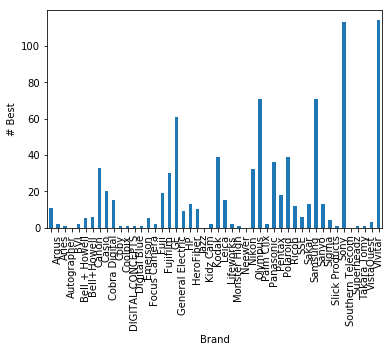

In [38]:
filt_res = res.copy()
filt_res['key'] = res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = filt_res.groupby('brand').agg({'key': 'sum'})
brand_hist = res_group.plot.bar()
brand_hist.legend().set_visible(False)
brand_hist.set_xlabel('Brand')
brand_hist.set_ylabel('# Best')
plt.show()

In [39]:
res_group.sort_values(by = 'key', ascending=False).head(10)

,key
brand,
Vivitar,114
Sony,113
Samsung,71
Olympus,71
GE,61
Polaroid,39
Kodak,39
Panasonic,36
Canon,33


##### Co-occurence matrix

In [41]:
# build co-occurence matrix with a set
bought_occ = pd.DataFrame(brands_clique_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_clique_set:
    bought_occ[b] = 0
bought_occ.index.rename('# is preferred over ->', inplace = True)

occ_res = res.copy()
occ_res['key'] = occ_res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = occ_res.groupby('id')

for c_id, c in res_group:
    winner_brand = c[c.key == 1].brand
    loser_brands = c[c.key == 0].brand
    for lb in loser_brands:
        bought_occ.loc[winner_brand, lb] += 1
        bought_occ.loc[lb, winner_brand] -= 1

#brand_data
print("Table dimension: ", bought_occ.shape)
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
bought_occ

Table dimension:  (51, 51)


,,Argus,Aries,Autographer,BVI,Bell + Howell,Bell+Howell,Canon,Casio,Cobra Digital,...,Samsung,Sanyo,Sigma,Slick Products,Sony,Southern Telecom,Superheadz,Takara Tomy,VistaQuest,Vivitar
# is preferred over ->,,,,,,,,,,,,,,,,,,,,,
,0,0,0,0,0,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,2
Argus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Aries,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Autographer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BVI,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Bell + Howell,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Bell+Howell,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Canon,-3,0,0,0,-1,-2,-1,0,-10,-2,...,-25,0,-2,0,-43,0,0,0,0,-5
Casio,-1,0,0,0,0,0,0,10,0,0,...,0,0,0,0,3,0,0,0,0,1


In [48]:
brand = "Canon"
bought_occ.loc[brand, bought_occ.loc[brand] != 0]

                 -3
BVI              -1
Bell + Howell    -2
Bell+Howell      -1
Casio           -10
Cobra Digital    -2
Fuji             -1
Fujifilm         -6
GE              -10
HP               -3
HeroFiber        -6
Kidz Cam         -1
Kodak            -1
Neewer            1
Nikon           -16
Olympus         -13
Panasonic        -8
Pentax          -11
Polaroid         -5
Ricoh            -2
SSE              -1
Samsung         -25
Sigma            -2
Sony            -43
Vivitar          -5
Name: Canon, dtype: int64

# OLD CODE: Create graph and cliques

In [43]:
# Convert string IDs to numeric IDs
name_id_mapping = {}
for i, record in enumerate(records):
    name_id_mapping[record['asin']] = i
    
adj_list = []
adj_set = []
for record in records:
    # Buy after viewing: add edge
    if 'related' in record and 'buy_after_viewing' in record['related']:
        av = record['related']['buy_after_viewing']
    else:
        av = []
    av = list(filter(lambda x: x in name_id_mapping, av))
    adj_list.append(sorted(set([name_id_mapping[x] for x in av])))
    
    # Bought together: remove edge (if added earlier)
    if 'related' in record and 'bought_together' in record['related']:
        bt = record['related']['bought_together']
    else:
        bt = []
    bt = list(filter(lambda x: x in name_id_mapping, bt))
    bt = [name_id_mapping[x] for x in bt]
    for o in bt:
        if o in adj_list[-1]:
            adj_list[-1].remove(o)
    adj_set.append(frozenset(adj_list[-1]))

# Transposed adjacency list (represents the incoming edges in every node)
adj_list_incoming = []
for adj in adj_list:
    adj_list_incoming.append([])
    
for i, adj in enumerate(adj_list):
    for node in adj:
        adj_list_incoming[node].append(i)

In [44]:
cliques = []
def extract_all_cliques(nodes, prev_list):
    count = 0
    m = 0 if len(prev_list) == 0 else bisect.bisect_right(nodes, prev_list[-1])
    for a in nodes[m:]:
        connected = True
        for test in prev_list:
            if test not in adj_set[a] or a not in adj_set[test]:
                connected = False
                break
        
        if connected:
            prev_list.append(a)
            if extract_all_cliques(adj_list[a], prev_list) == 0:
                cliques.append(prev_list.copy())
                count += 1
            prev_list.pop()
    return count

In [45]:
cliques = []
print(extract_all_cliques(range(len(adj_list)), []), 'cliques found')

1244 cliques found


In [9]:
for c in cliques:
    if len(c) < 2:
        continue
    for i in c:
        print('*',records[i]['title'], ' - $', records[i]['price'])
    print('------')

* Southern Telecom Emerson Action Camera Black Digital Cameras  - $ 36.87
* Emerson EVC355BLHD Action Video Camera with 1.2-Inch LCD (Blue)  - $ 40.39
------
* Canon Rebel T5i Digital SLR Camera and 18-55mm EF-S IS STM Lens Kit  - $ 749.0
* Canon EOS Rebel T5i 18.0 MP CMOS Digital Camera with EF-S 18-55mm f/3.5-5.6 IS STM Zoom Lens + EF 75-300mm f/4-5.6 III Telephoto Zoom Lens + Telephoto &amp; Wide Angle Lenses + 12pc Bundle 32GB Deluxe Accessory Kit  - $ 849.0
------
* Nikon COOLPIX S02 13.2 MP Digital Camera with 3x Zoom NIKKOR Glass Lens and Full 1080p HD Video (Pink)  - $ 84.95
* Nikon COOLPIX S01 10.1 MP Digital Camera with 3x Zoom NIKKOR Glass Lens (Pink)  - $ 95.88
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Olympus Stylus VG-180 16-Megapixel 5X 26mm Wide Optical Zoom 2.7 Inch LCD - Black  - $ 49.99
* Kodak Easyshare C195 Digital Camera (Red)  - $ 47.44
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Kodak Easyshar

In [72]:
fan_in = list(map(lambda x: len(x), adj_list_incoming))
fan_out = list(map(lambda x: len(x), adj_list))
df = pd.DataFrame()
df['fan_in'] = fan_in
df['fan_out'] = fan_out
df.index = pd.DataFrame(records)['asin']
df.sort_values('fan_in', ascending=False).head()

,fan_in,fan_out
asin,,
B003VTZE1M,78,1
B00728ZBA2,60,2
B003VTZE1W,32,2
B0096W1OKS,30,0
B00AWYN182,29,0


# OLD Brand analysis

#### Find brands in cliques

In [106]:
brands = []
dimension_min = 2

for c in cliques:
    if len(c) < dimension_min:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands.append(g.records[i]['brand'])
            
print(str(len(brands)) + " products are associated to a brand.")
brands_set= sorted(set(brands))
print("There are " + str(len(brands_set)) + " brands in cliques.")
print(brands_set)

165 products are associated to a brand.
There are 20 brands in cliques.
['Canon', 'Casio', 'Emerson', 'Focus Camera', 'Fujifilm', 'GE', 'HeroFiber', 'Kodak', 'Leica', 'Lytro', 'Nikon', 'Olympus', 'Panasonic', 'Pentax', 'Ricoh', 'Sakar', 'Sigma', 'Sony', 'Southern Telecom', 'Vivitar']


In [107]:
brand_data = pd.DataFrame(brands_set, columns = ['brand'])
#brand_data = brand_data.replace("", "Empty")
brand_data = brand_data.set_index('brand')
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index().head()

""
brand
Canon
Casio
Emerson
Focus Camera
Fujifilm


#### Find most sold brand in each clique according to sale rank

In [108]:
brand_data['most sold'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check sale rank category is the same for every article
    checkCat = []
    for i in c:
        checkCat.append(records[i]['salesRankCat'])
    if len(set(checkCat)) != 1:
        continue
    # min sale rank
    sr_min = min([records[i]['salesRankPos'] for i in c])
    # most sold products (some products may have the same rate)
    most_sold = [i for i in c if records[i]['salesRankPos'] == sr_min]
    # check that not every product is most sold
    if len(most_sold) < len(c):
    # increment most sold brands
        for i in most_sold:
            brand_data.loc[records[i]['brand'], 'most sold'] += 1
            

KeyError: 'the label [Unknown] is not in the [index]'

#### Find most rated brand in each clique according to avg rate

In [109]:
brand_data['most rated'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max rating
    r_max = max([records[i]['average_rating'] for i in c])
    # most rated products (some products may have the same rate)
    most_rate = [i for i in c if records[i]['average_rating'] == r_max]
    # check that there is at least a product less rated than the others
    if len(most_rate) < len(c):
    # increment most rated brands
        for i in most_rate:
            brand_data.loc[records[i]['brand'], 'most rated'] += 1


KeyError: 'the label [Samsung] is not in the [index]'

#### Find  most expensive and cheapest brand in each clique 

In [77]:
brand_data['cheapest'] = 0
brand_data['most expensive'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max and min price
    p_max = max([records[i]['price'] for i in c])
    p_min = min([records[i]['price'] for i in c])
    # most expensive products (some products may have the same price)
    most_exp = [i for i in c if records[i]['price'] == p_max]
    # check that there is at least a product cheaper than the others
    if len(most_exp) < len(c):
    # increment most expensive brands
        for i in most_exp:
            brand_data.loc[records[i]['brand'], 'most expensive'] += 1
    # cheapest products (some products may have the same price)
    cheap = [i for i in c if records[i]['price'] == p_min]
    # check that there is at least a product more expensive than the others
    if len(cheap) < len(c):
    # increment cheapest brands
        for i in cheap:
            brand_data.loc[records[i]['brand'], 'cheapest'] += 1
            

#### Find most sold brand in each clique according to fan in

In [78]:
brand_data['most bought'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check max fan in
    v_max = max([fan_in[i] for i in c])
    most_bought = [i for i in c if fan_in[i] == v_max]
    # the products cannot be compared because they ALL have the same fan in
    if len(most_bought) == len(c):
        continue
    # however, if multiple products have same fan in and there are other products, the each of the former is incremented
    for i in most_bought:
        brand_data.loc[records[i]['brand'], 'most bought'] += 1
    

In [79]:
# filter dataframe
#brand_data = brand_data.rename(index={'': 'empty'})
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index()

,most sold,most rated,cheapest,most expensive,most bought
brand,,,,,
Canon,2,1,3,1,2
Casio,0,0,0,0,0
Emerson,0,1,0,1,0
Focus Camera,2,3,1,3,1
Fujifilm,0,0,0,0,0
GE,2,2,2,0,0
HeroFiber,0,0,0,0,0
Kodak,1,1,2,0,2
Leica,0,0,0,0,0


In [21]:
print(brand_data.loc['Samsung'])
print(brand_data.loc['LG'])

KeyError: 'the label [Samsung] is not in the [index]'

#### "Co occurence" matrix

For each bran row, the brand column indicates how many time it lost in terms of fan in

In [80]:
print("Fan-in analysis (most bought).")
bought_occ = pd.DataFrame(brands_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_set:
    bought_occ[b] = 0
bought_occ.index.rename('most bought', inplace = True)
    
# auxiliary statistics
clique_count = 0
valid_clique_count = 0
for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check all different brands
    clique_count += 1
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    #print(brand_check)
    valid_clique_count += 1
    v_max = max([fan_in[i] for i in c])
    # if same fan in there is no best: eg (samsung, 4) (HP, 4) none of the two is incremented
    most_bought = [i for i in c if fan_in[i] == v_max]
    others = [i for i in c if fan_in[i] != v_max]
    for i in most_bought:
        for j in others:
            bought_occ.loc[records[i]['brand'], records[j]['brand']] += 1
    
    
#brand_data
print("Percentage of valid cliques: ", valid_clique_count/clique_count)
print("Table dimension: ", bought_occ.shape)
#bought_occ

Fan-in analysis (most bought).
Percentage of valid cliques:  0.1375
Table dimension:  (20, 20)


In [81]:
# filter table
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
#bought_occ.drop(["", "Unknown"], inplace=True, axis=1)
#bought_occ.drop(["", "Unknown"], inplace=True, axis=0)
#bought_occ.loc['Samsung']
bought_occ

,Canon,Focus Camera,Nikon,Olympus,Pentax
most bought,,,,,
Canon,0,1,1,0,0
Focus Camera,1,0,0,0,0
Kodak,0,0,0,2,0
Nikon,0,1,0,0,0
Ricoh,0,0,0,0,1


In [82]:
for b in bought_occ.index:
    #print('Brand: ', b, ' , other choices: ', bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('Brand: ', b)
    print(bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('------')


Brand:  Canon
Focus Camera    1
Nikon           1
Name: Canon, dtype: int64
------
Brand:  Focus Camera
Canon    1
Name: Focus Camera, dtype: int64
------
Brand:  Kodak
Olympus    2
Name: Kodak, dtype: int64
------
Brand:  Nikon
Focus Camera    1
Name: Nikon, dtype: int64
------
Brand:  Ricoh
Pentax    1
Name: Ricoh, dtype: int64
------


In [83]:
b_dict = {}
for b in bought_occ.index:
    row = bought_occ.loc[b, bought_occ.loc[b] != 0]
    l = [(i, row[i]) for i in row.index]
    #print('Brand: ', b, ', alternatives: ', l)
    b_dict[b] = l

brand = 'Samsung'
print('Alternatives to: ', brand)
print(b_dict[brand], sum(list(map((lambda x: x[1]), b_dict[brand]))))

Alternatives to:  Samsung


KeyError: 'Samsung'

### Feature analysis

Find how many fan-in winners have keyword

In [87]:
keyword = "lcd"

keyword_count = 0
total_count = 0
for c in cliques:
    if len(c) != 2:
        continue
    # check max fan in
    v_max = max([fan_in[i] for i in c])
    #most_bought = [i for i in c if fan_in[i] == v_max]
    # TODO: try rank
    for i in c:
        total_count += 1
        if keyword in records[i]['title']:
            if fan_in[i] == v_max:
                keyword_count += 1

if not total_count:
    print("No product found")
else:
    print(keyword_count/total_count)

0.0
